In [6]:
import numpy as np
import time

filename = 'treecode_out_EQUILIBRIUM_1.txt'

# Open the file and read initial information
fp = open(filename, 'r')

Npart = int(fp.readline())       # Number of particles
Nd = int(fp.readline())          # Number of dimensions (usually 3)

fp.seek(0)                       # Reset file pointer to beginning
Nlines = len(fp.readlines())    # Count total lines in the file
fp.close()

Nlines_in_snapshot = 3 + 3*Npart
Nsnapshots = Nlines//Nlines_in_snapshot

x = np.empty([Nsnapshots,Npart,Nd])
v = np.empty([Nsnapshots,Npart,Nd])

print("Npart =", Npart)
print("Nd =", Nd)
print("Nlines =", Nlines)
print("Nlines_in_snapshot =", Nlines_in_snapshot)
print("Nsnapshots =",Nsnapshots)
print(x.shape)
print(v.shape)

# read the masses:
start_time=time.time()

masses = np.genfromtxt(filename,skip_header=3,max_rows=Npart)

# read the times, positions and velocities
t = np.empty([Nsnapshots])

for i_snapshot in range(Nsnapshots):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_m = initial_line + 3
    initial_line_x = initial_line_m+Npart
    initial_line_v = initial_line_x+Npart
    
    t[i_snapshot] = np.genfromtxt(filename,skip_header=initial_line+2,max_rows=1)
    x[i_snapshot] = np.genfromtxt(filename,skip_header=initial_line_x,max_rows=Npart)
    v[i_snapshot] = np.genfromtxt(filename,skip_header=initial_line_v,max_rows=Npart)

end_time = time.time()
print(end_time-start_time)

Npart = 30000
Nd = 3
Nlines = 6030201
Nlines_in_snapshot = 90003
Nsnapshots = 67
(67, 30000, 3)
(67, 30000, 3)
342.9935131072998


## Satellite Propulsion Analysis

In this section, we study the orbital evolution of a satellite moving within a galactic disk.  
We extracted the trajectory from two different scenarios:

- **Equilibrium Disk**: No significant instabilities.
- **Bar Formation Disk**: Presence of strong non-axisymmetric structures.

The main goal is to quantify:

- How much thrust (Delta-v) is needed to maintain a stable orbit.
- How orbital properties (radius, velocity) evolve under different galactic conditions.

This analysis provides insights into the challenges of propulsion in dynamically active environments.

In [8]:
# Pick a random particle relatively far from the center (e.g., r > 2 kpc)
radii = np.sqrt(x[0,:,0]**2 + x[0,:,1]**2 + x[0,:,2]**2)

# Select candidates
candidate_indices = np.where(radii > 2)[0]

# Pick one satellite
satellite_index = candidate_indices[0]  # or np.random.choice(candidate_indices)

print(f"Selected satellite index: {satellite_index}")

Selected satellite index: 0


## Satellite Orbit Visualization

The animation below shows the satellite's orbit projected onto the XY plane.  
In an equilibrium disk, we expect the orbit to remain nearly circular and stable.  
In a disk experiencing bar formation, the orbit may become perturbed, leading to deviations from circularity and increased propulsion demands.

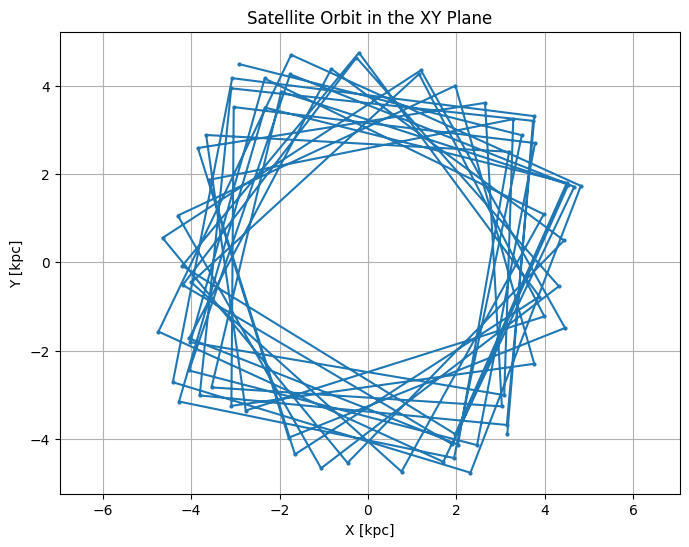

In [10]:
import matplotlib.pyplot as plt

# Extract orbit
satellite_orbit = x[:, satellite_index, :]

# Plot
fig = plt.figure(figsize=(8,6))
plt.plot(satellite_orbit[:,0], satellite_orbit[:,1], '-o', markersize=2)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title('Satellite Orbit in the XY Plane')
plt.grid()
plt.axis('equal')
plt.show()

In [12]:
# satellite da studiare
satellite_idx = 0  

# Estrai posizioni e velocità solo di quel satellite nel tempo
x_satellite = x[:, satellite_idx, :]
v_satellite = v[:, satellite_idx, :]

radii = np.linalg.norm(x_satellite[:, :2], axis=1)  # solo X e Y

# Raggio medio
raggio_medio = np.mean(radii)

print(f"Raggio orbitale medio: {raggio_medio:.2f} kpc")

# Calcolo della velocità a ogni snapshot
velocities = np.linalg.norm(v_satellite[:, :2], axis=1)  # solo componenti X e Y

# Velocità media
velocità_media = np.mean(velocities)

print(f"Velocità orbitale media: {velocità_media:.2f} internal units")

Raggio orbitale medio: 4.62 kpc
Velocità orbitale media: 5.10 internal units


## Delta-v Requirements

We compute the incremental Delta-v at each timestep as:

$$
\Delta v_i = |\mathbf{v}_{i+1} - \mathbf{v}_i|
$$

The total cumulative Delta-v gives a proxy for the fuel requirements needed to maintain a stable trajectory.  
We compare the total Delta-v in the equilibrium case and in the bar formation case.

Higher Delta-v requirements indicate that the satellite must work harder (expend more fuel) to counteract gravitational perturbations caused by the bar instability.

In [13]:
#l'orbita è quasi circolare

G = 1.0  # costante gravitazionale in internal units
M_tot = np.sum(masses)  # massa totale del sistema

# Raggio iniziale (media calcolata prima)
r_initial = raggio_medio

# Raggio finale (obiettivo: +1 kpc)
r_final = r_initial + 1.0  # 1 kpc di incremento

# Velocità iniziale circolare
v_initial = np.sqrt(G * M_tot / r_initial)

# Velocità finale circolare
v_final = np.sqrt(G * M_tot / r_final)

# Delta-v richiesto
delta_v = abs(v_final - v_initial)

print(f"Delta-v necessario per passare da {r_initial:.2f} kpc a {r_final:.2f} kpc: {delta_v:.4f} internal units")

Delta-v necessario per passare da 4.62 kpc a 5.62 kpc: 0.2539 internal units


In [16]:
import matplotlib.animation as animation

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_title('Satellite Orbit Animation')

# Line and point to update
line, = ax.plot([], [], lw=1, color='blue')
point, = ax.plot([], [], 'o', color='red')

# Positions of the satellite
x_pos = x_satellite[:, 0]
y_pos = x_satellite[:, 1]

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def update(frame):
    if frame == 0:
        line.set_data([], [])
        point.set_data([x_pos[0]], [y_pos[0]])  
    else:
        line.set_data(x_pos[:frame], y_pos[:frame])
        point.set_data([x_pos[frame]], [y_pos[frame]])  
    return line, point

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(x_pos), init_func=init,
    blit=True, interval=100
)

# Save the GIF
ani.save('satellite_orbit.gif', writer='pillow', fps=10)

plt.close()

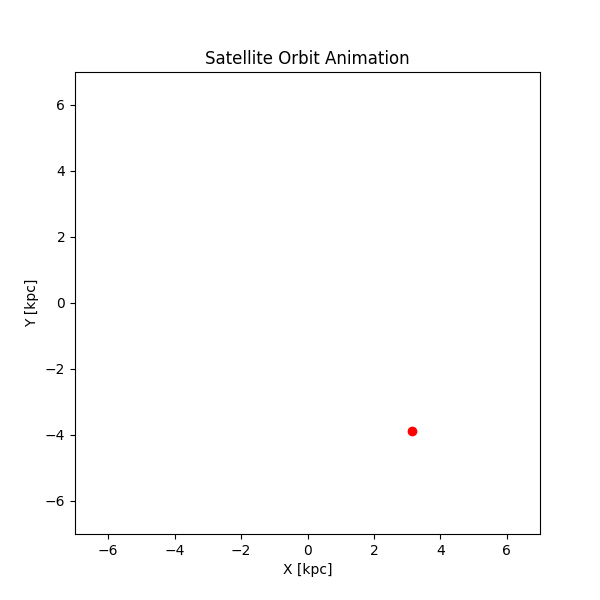

In [17]:
from IPython.display import Image

# Display the saved GIF
Image(filename="satellite_orbit.gif")

## Propulsion Analysis: Instantaneous Delta-v

To evaluate the propulsion requirements for maintaining the satellite's orbit, we computed the instantaneous Delta-v needed at each timestep.

The Delta-v quantifies the small velocity corrections necessary to compensate for orbital drift or instabilities in the stellar disk potential.

The resulting plot shows the Delta-v demand across time: 
- In an equilibrium disk, we expect small and relatively stable Delta-v values.
- In the bar formation scenario, larger fluctuations may appear due to the non-axisymmetric perturbations in the potential.

This gives a first direct insight into the dynamical impact of the disk's evolution on spacecraft navigation.

## Propulsion Analysis: Cumulative Delta-v

We also calculated the **cumulative Delta-v** over time.

This value represents the total velocity change a satellite would need to apply to remain in orbit over the considered time span.

Comparing cumulative Delta-v across equilibrium and unstable disks allows us to quantify:
- How much more challenging it is to maintain orbital stability in a dynamically evolving galaxy.
- The propulsion effort needed in different gravitational environments.

In future extensions, we could relate these cumulative Delta-v budgets to realistic spacecraft fuel consumption and propulsion system design!

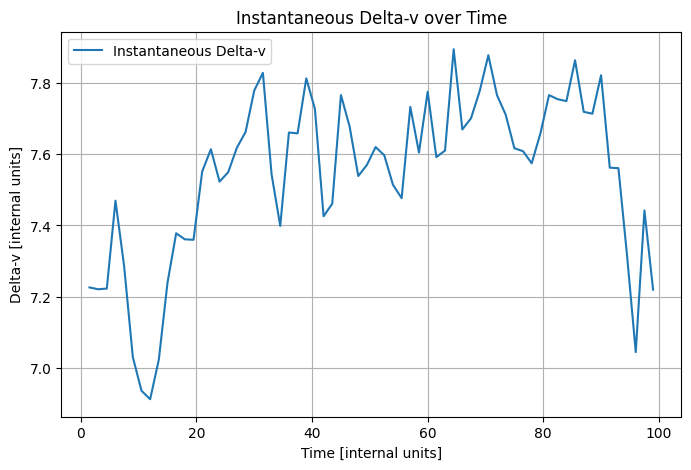

Total Delta-v required: 497.9134 [internal units]
Mean Delta-v per timestep: 7.544143 [internal units]


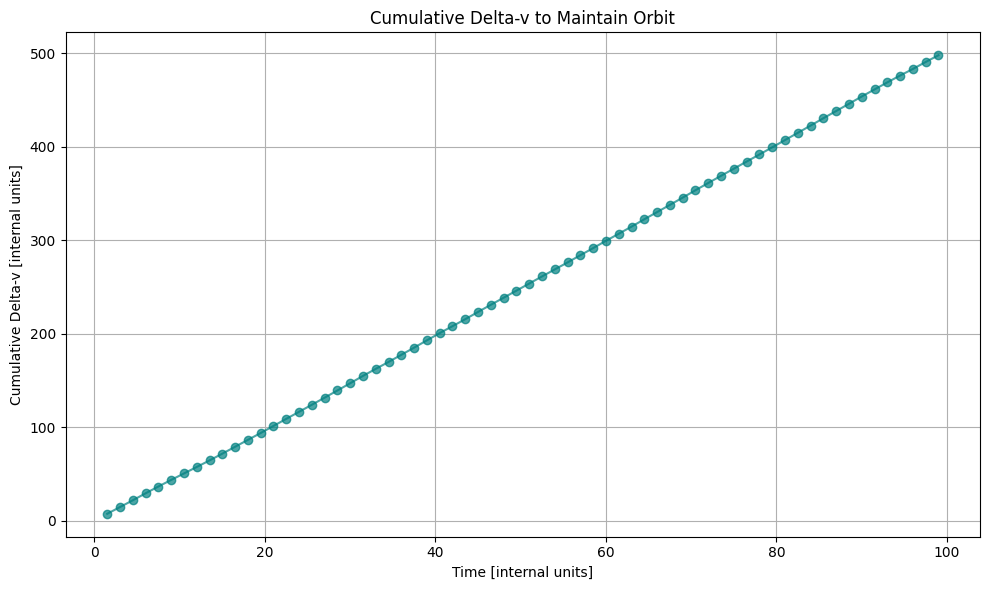

In [19]:
# Calcolo Delta-v ad ogni timestep per il satellite
delta_v = np.linalg.norm(v_satellite[1:] - v_satellite[:-1], axis=1)

# Tempo associato ad ogni salto (se costante)
dt = t[1] - t[0]

# Plot Delta-v
plt.figure(figsize=(8,5))
plt.plot(t[1:], delta_v, label='Instantaneous Delta-v')
plt.xlabel("Time [internal units]")
plt.ylabel("Delta-v [internal units]")
plt.title("Instantaneous Delta-v over Time")
plt.grid()
plt.legend()
plt.show()

# Calcolo Delta-v cumulative e media
total_delta_v = np.sum(delta_v)
mean_delta_v = np.mean(delta_v)

print(f"Total Delta-v required: {total_delta_v:.4f} [internal units]")
print(f"Mean Delta-v per timestep: {mean_delta_v:.6f} [internal units]")

# Grafico cumulativo del Delta-v
cumulative_delta_v = np.cumsum(delta_v)

plt.figure(figsize=(10,6))
plt.plot(t[1:], cumulative_delta_v, marker='o', linestyle='-', color='teal', alpha=0.7)
plt.xlabel("Time [internal units]")
plt.ylabel("Cumulative Delta-v [internal units]")
plt.title("Cumulative Delta-v to Maintain Orbit")
plt.grid(True)
plt.tight_layout()
plt.show()

# Satellite Propulsion Analysis in Equilibrium Disk

In this section, we analyzed the propulsion requirements for maintaining a satellite in orbit within an equilibrium galactic disk:

Instantaneous Delta-v: The satellite requires small continuous velocity corrections, fluctuating between approximately 7.2 and 7.8 [internal units] to counteract moderate gravitational perturbations.

Total Delta-v: Over the full simulation, the cumulative Delta-v needed to maintain orbit stability is about 497.9 [internal units].

Linear Growth: The cumulative Delta-v shows a steady linear trend, suggesting that the satellite undergoes regular and consistent corrections throughout its orbit.

These results are consistent with the behavior expected in a stable disk: the orbit is subject to minor fluctuations but remains globally stable without large deviations.

Insight: This regular and moderate propulsion requirement contrasts with the expected behavior in the bar formation scenario, where stronger asymmetries and chaotic motions will likely increase the Delta-v demand.

# Conclusions
In this project, we conducted a comprehensive study of disk dynamics and satellite propulsion within galactic environments:

We compared an equilibrium disk and a disk undergoing bar instability by analyzing their structural evolution, Lagrangian radii behavior, bar strength, angular momentum conservation, and total energy trends.

A satellite was introduced and tracked across the simulated snapshots to investigate orbital dynamics and propulsion requirements in both cases.

In the equilibrium case, we observed stable orbits requiring small and regular Delta-v maneuvers to maintain position.

The methodology developed here sets the stage for studying more extreme cases, such as disks with bar formation, where the propulsion budget and orbital maintenance strategies are expected to differ significantly.

This project not only highlights the importance of gravitational perturbations on orbital stability but also provides a practical framework for future space mission planning in complex gravitational environments.